The following code provides a Collaborative Filtering (CF) Implementation, Training, and Testing:

1. Data Collection, Processing, Splitting into Train/Test
2. Model Building
3. Training CF Model on Custom Objective Functions
4. Evaluating Different Objective Functions

**1. Data Collection, Processing, Splitting into Train/Test** \
The goal of this section is to process the dataset in "/dataset/ratings". \
70% of the resulting data is put into the training matrix and the remaining 30% is held in the testing matrix. \
Each movie and user is sequentially assigned an ID that becomes their matrix index as well.

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

data_df = pd.read_csv('./dataset/ratings.dat', sep=',', names=["UserID", "MovieID", "Rating", "Timestamp"], engine='python')

# Filter out only the first 2000 users and first 2000 movies
data_df = data_df[data_df['UserID'] <= 2000]
data_df = data_df[data_df['MovieID'] <= 2000]

# First, generate dictionaries for mapping old id to new id for users and movies
unique_MovieID = data_df['MovieID'].unique()
unique_UserID = data_df['UserID'].unique()
j = 0
user_old2new_id_dict = dict()
for u in unique_UserID:
    user_old2new_id_dict[u] = j
    j += 1
j = 0
movie_old2new_id_dict = dict()
for i in unique_MovieID:
    movie_old2new_id_dict[i] = j
    j += 1
    
# Then, use the generated dictionaries to reindex UserID and MovieID in the data_df
user_list = data_df['UserID'].values
movie_list = data_df['MovieID'].values
for j in range(len(data_df)):
    user_list[j] = user_old2new_id_dict[user_list[j]]
    movie_list[j] = movie_old2new_id_dict[movie_list[j]]
data_df['UserID'] = user_list
data_df['movieID'] = movie_list

# generate train_df with 70% samples and test_df with 30% samples, and there should have no overlap between them.
np.random.seed(0)
train_index = np.random.random(len(data_df)) <= 0.7
train_df = data_df[train_index]
test_df = data_df[~train_index]

# generate train_mat and test_mat
num_user = len(data_df['UserID'].unique())
num_movie = len(data_df['MovieID'].unique())

train_mat = coo_matrix((train_df['Rating'].values, (train_df['UserID'].values, train_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float)
test_mat = coo_matrix((test_df['Rating'].values, (test_df['UserID'].values, test_df['MovieID'].values)), shape=(num_user, num_movie)).astype(float)

This marks the termination of the data collection and processing step.
We have 2 matrices, $train\_mat$ and $test\_mat$. \
Both matrices have the dimensions: Number of Users $\times$ Number of Movies or $numU \times numM$ \
where $train\_mat[i][j]$ or $test\_mat[i][j]$ is user i's rating for movie j.

**Now, we move to section 2: Model Building** and **section 3: Training CF Model on Custom Objective Functions** \
In order to build the model, we need to encode the information into 2 low rank matrices, such that \

$ R = UM $, where $U$ is the user matrix and and $M$ is the movie matrix, \
whose dimensions are $numU \times k$ and $k \times numM$ respectively, where $k << min\{numU, numM\}$ \


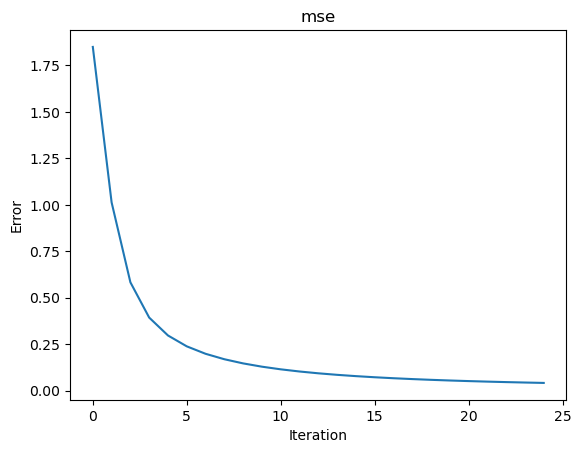

Objective function: mse, Performance metric: 0.9333652257523021


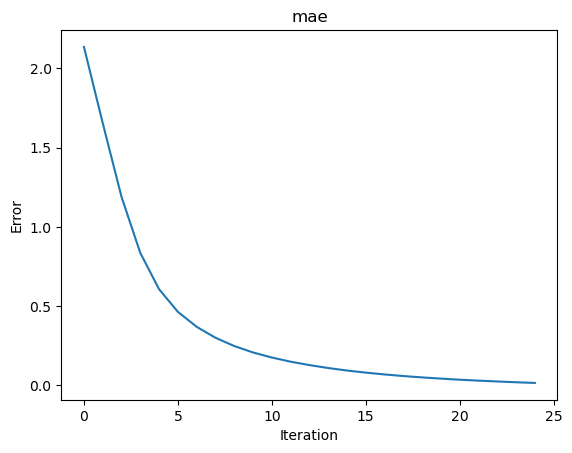

Objective function: mae, Performance metric: 0.7501219035703027


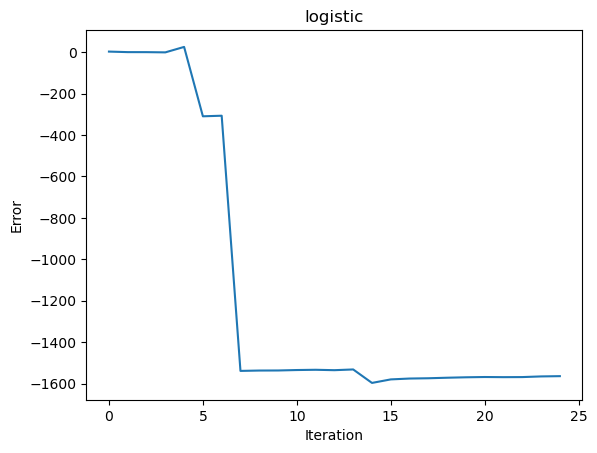

C:\Users\Caleb Lee\AppData\Local\Temp\ipykernel_4068\3322573846.py:92: RuntimeWarning: invalid value encountered in log
  errors[i] = -actual_rating * np.log(predicted_rating) - (1 - actual_rating) * np.log(1 - predicted_rating)


Objective function: logistic, Performance metric: nan


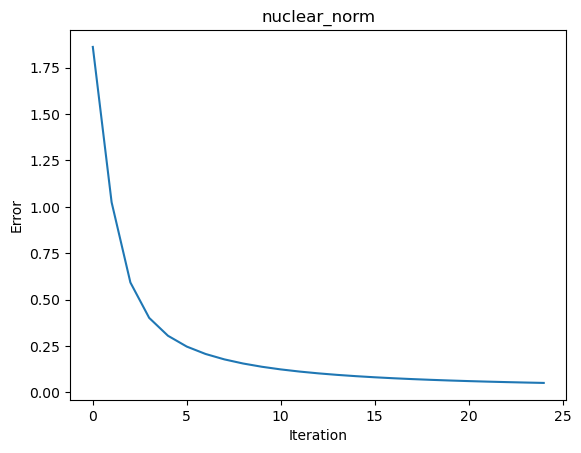

Objective function: nuclear_norm, Performance metric: 0.9339213111591615


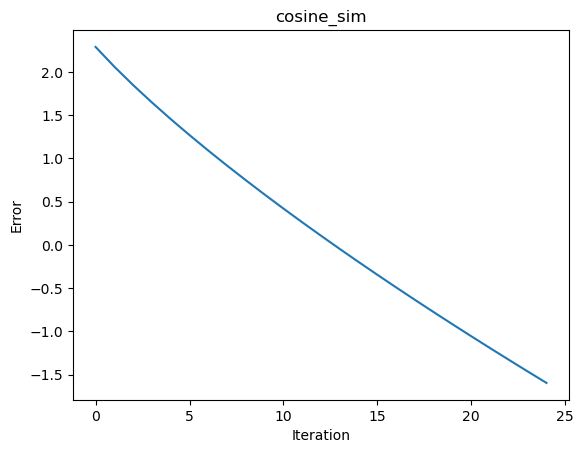

Objective function: cosine_sim, Performance metric: 0.07680270591129386


In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt

def collaborative_filtering(train_mat, num_latent_features=10, num_iterations=50, learning_rate=0.001, reg_param=0.02, nuclear_norm_param=0.01, objective_func='mse'):
    """
    Implement collaborative filtering with different objective functions and nuclear norm regularization.

    Args:
        train_mat (scipy.coo_matrix): The training matrix with user ratings for movies.
        num_latent_features (int): The number of latent features to use in the low-rank approximation.
        num_iterations (int): The number of iterations to perform during optimization.
        learning_rate (float): The learning rate for gradient descent optimization.
        reg_param (float): The regularization parameter to prevent overfitting.
        nuclear_norm_param (float): The nuclear norm regularization parameter to encourage low-rank interpretations.
        objective_func (str): The objective function to use ('mse', 'mae', 'logistic', 'nuclear_norm', or 'cosine_sim').

    Returns:
        numpy.ndarray: User latent feature matrix.
        numpy.ndarray: Movie latent feature matrix.
        numpy.ndarray: Average error across iterations.
    """
    num_users, num_movies = train_mat.shape
    
    # Initialize user and movie latent feature matrices
    user_features = np.random.rand(num_users, num_latent_features)
    movie_features = np.random.rand(num_movies, num_latent_features)
    
    users = train_mat.row
    movies = train_mat.col
    ratings = train_mat.data
    num_pts = len(users)
    avg_iter_error = np.empty(num_iterations)
    
    for iteration in range(num_iterations):
        for i in range(num_pts):
            user_id, movie_id, rating = users[i], movies[i], ratings[i]
            predicted_rating = np.dot(user_features[user_id], movie_features[movie_id])
            error = rating - predicted_rating
            avg_iter_error[iteration] += error

            # Update user and movie latent feature vectors based on the objective function
            if objective_func == 'mse':
                user_grad = -error * movie_features[movie_id] + reg_param * user_features[user_id]
                movie_grad = -error * user_features[user_id] + reg_param * movie_features[movie_id]
            elif objective_func == 'mae':
                user_grad = -np.sign(error) * movie_features[movie_id] + reg_param * user_features[user_id]
                movie_grad = -np.sign(error) * user_features[user_id] + reg_param * movie_features[movie_id]
            elif objective_func == 'logistic':
                coeff = (1-rating)/(1-predicted_rating) - rating/predicted_rating
                user_grad = coeff * movie_features[movie_id] + reg_param * user_features[user_id]
                movie_grad = coeff * user_features[user_id] + reg_param * movie_features[movie_id]
            elif objective_func == 'nuclear_norm':
                user_grad = -error * movie_features[movie_id] + reg_param * user_features[user_id] + 2 * nuclear_norm_param * np.linalg.norm(user_features[user_id], ord=1)
                movie_grad = -error * user_features[user_id] + reg_param * movie_features[movie_id] + 2 * nuclear_norm_param * np.linalg.norm(movie_features[movie_id], ord=1)
            elif objective_func == 'cosine_sim':
                user_vec = user_features[user_id]
                movie_vec = movie_features[movie_id]
                
                # Normalize user and movie vectors
                user_vec_norm = user_vec / np.linalg.norm(user_vec)
                movie_vec_norm = movie_vec / np.linalg.norm(movie_vec)
                                
                # Calculate gradients
                user_grad = -movie_vec_norm / (np.linalg.norm(user_vec) * np.linalg.norm(movie_vec))
                movie_grad = -user_vec_norm / (np.linalg.norm(user_vec) * np.linalg.norm(movie_vec))    
            
            user_features[user_id] -= learning_rate * user_grad
            movie_features[movie_id] -= learning_rate * movie_grad
        avg_iter_error[iteration] /= num_pts
    return user_features, movie_features, avg_iter_error

def evaluate_model(test_mat, user_features, movie_features, objective_func='mse'):
    """
    Evaluate the collaborative filtering model on the test data with different objective functions.
    """
    users = test_mat.row
    movies = test_mat.col
    ratings = test_mat.data
    num_pts = len(users)
    errors = np.empty(num_pts)

    for i in range(num_pts):
        user_id, movie_id, actual_rating = users[i], movies[i], ratings[i]
        predicted_rating = np.dot(user_features[user_id], movie_features[movie_id])

        if objective_func == 'mse':
            errors[i] = (actual_rating - predicted_rating) ** 2
        elif objective_func == 'mae':
            errors[i] = abs(actual_rating - predicted_rating)
        elif objective_func == 'logistic':
            errors[i] = -actual_rating * np.log(predicted_rating) - (1 - actual_rating) * np.log(1 - predicted_rating)
        elif objective_func == 'nuclear_norm':
            errors[i] = (actual_rating - predicted_rating) ** 2
        elif objective_func == 'cosine_sim':
            user_vec = user_features[user_id]
            movie_vec = movie_features[movie_id]
            
            # Normalize user and movie vectors
            user_vec_norm = user_vec / np.linalg.norm(user_vec)
            movie_vec_norm = movie_vec / np.linalg.norm(movie_vec)
            
            # Calculate cosine similarity
            cosine_sim = np.dot(user_vec_norm, movie_vec_norm)
            
            # Calculate error based on cosine similarity
            errors[i] = 1 - cosine_sim

    if objective_func == 'mse' or objective_func == 'nuclear_norm':
        return np.sqrt(np.mean(errors))
    elif objective_func == 'mae' or objective_func == 'logistic' or objective_func == 'cosine_sim':
        return np.mean(errors)

def plot_iterations(objective_func, avg_error):
    plt.plot(avg_error)
    plt.title(objective_func)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.show()

objective_functions = ['mse', 'mae', 'logistic', 'nuclear_norm', 'cosine_sim']

for objective_func in objective_functions:
    user_features, movie_features, avg_error = collaborative_filtering(train_mat, num_latent_features=5, num_iterations=25, learning_rate=0.001, reg_param=0.01, nuclear_norm_param=0.001, objective_func=objective_func)
    plot_iterations(objective_func, avg_error)
    performance_metric = evaluate_model(test_mat, user_features, movie_features, objective_func=objective_func)
    print(f"Objective function: {objective_func}, Performance metric: {performance_metric}")

training 2 latent num
training 6 latent num
training 10 latent num
training 14 latent num
training 18 latent num
training 22 latent num
training 26 latent num
training 30 latent num
training 34 latent num
training 38 latent num


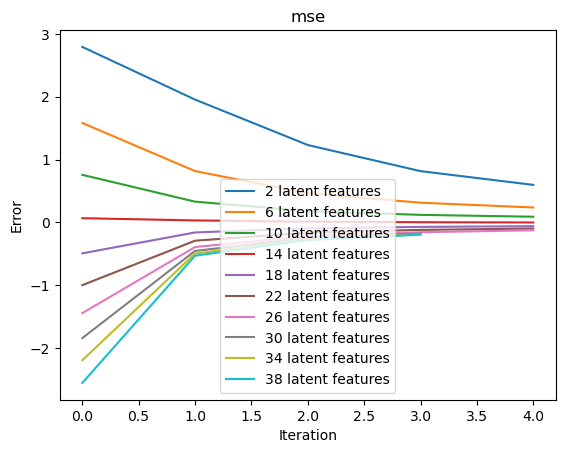

In [5]:
def plot_latent(objective_func, avg_errors):
    for latent_num, avg_error in avg_errors:
        plt.plot(avg_error, label=f'{latent_num} latent features')
    plt.title(objective_func)
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

avg_errors = []
for latent_num in range(2, 40, 4):
    user_features, movie_features, avg_error = collaborative_filtering(train_mat, num_latent_features=latent_num, num_iterations=5, learning_rate=0.001, reg_param=0.01, nuclear_norm_param=0.001, objective_func='mse')
    avg_errors.append((latent_num, avg_error))
    print(f'training {latent_num} latent num')
    performance_metric = evaluate_model(test_mat, user_features, movie_features, objective_func='mse')
plot_latent('mse', avg_errors)